In [1]:
# %matplotlib notebook
# %matplotlib inline
import numpy as np
import pickle
np.random.seed(123)
import collections, copy, pickle
from importlib import reload
from dateutil.parser import parse
import scipy.linalg
import pandas as pd
import sklearn
# import scipy.sparse
# import scipy.sparse.linalg
import matplotlib
# import matplotlib.transforms
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
# import mpl_toolkits.mplot3d.axes3d as p3
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator, FormatStrFormatter
# from matplotlib import animation
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
# rcParams['text.usetex'] = True
from IPython.display import HTML
# from numba import jit, njit, float32, prange
# import cProfile

In [2]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [3]:
import util.plot
import util.string

In [4]:
# https://github.com/pbloem/machine-learning/blob/master/worksheets/Worksheet%202%2C%20Sklearn.ipynb

In [5]:
# data = pd.read_csv('ODI-2019-clean.csv', sep=';')
fn = 'ODI-2019-clean.pkl'
# load (old) data from disk
with open(fn, 'rb') as f:
    data = pickle.load(f)

In [6]:
data.describe()

,Unnamed: 0,Stress level,Day,Month,Year,Neighbours,Money
count,276.000000,276.000000,262.000000,262.000000,201.000000,261.000000,276.000000
mean,137.500000,38.500000,14.419847,6.419847,1993.985075,4.877395,35.241884
std,79.818544,33.933571,8.503733,3.411619,3.464791,8.174556,40.238578
min,0.000000,0.000000,0.000000,0.000000,1969.000000,0.000000,0.000000
25%,68.750000,10.000000,8.000000,4.000000,1993.000000,2.000000,1.000000
50%,137.500000,30.000000,13.000000,6.000000,1995.000000,3.000000,10.000000
75%,206.250000,65.000000,21.000000,9.000000,1996.000000,6.000000,80.000000
max,275.000000,100.000000,31.000000,12.000000,2001.000000,80.000000,100.000000


In [7]:
data.head()

,Unnamed: 0,Timestamp,ML,IR,Stat,DB,Gender,Chocolate,Stand Up,Rand,Good day (1),Good day (2),Stress level,Programme,Day,Month,Year,Neighbours,Money,Bedtime
0,0,3/27/2019 10:16:11,Yes,Yes,Yes,Yes,unknown,Slim,no,6,sun,lecture,30.0,AI,NaN,NaN,NaN,3.0,100.0,23:00:00
1,1,4/1/2019 15:58:21,No,No,Yes,Yes,male,Fat,no,7,DM,AI,1.0,AI,9.0,7.0,1992.0,1.0,0.0,03:00:00
2,2,4/1/2019 15:59:07,Yes,Yes,Unknown,Yes,male,Neither,unknown,0,0,0,100.0,CS,4.0,8.0,1995.0,0.0,0.0,00:00:00
3,3,4/1/2019 15:59:30,Yes,Yes,Yes,Yes,male,Fat,no,"1,645",Winning,Food,0.0,CS,29.0,9.0,1993.0,2.0,42.0,00:30:00
4,4,4/1/2019 15:59:58,No,Yes,Yes,Yes,male,Neither,no,66,kiss,love,100.0,CS,12.0,4.0,NaN,2.0,10.0,20:00:00


## Categorical models

In [8]:
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

# from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Discretization

https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features

https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization_strategies.html#sphx-glr-auto-examples-preprocessing-plot-discretization-strategies-py

Strategies:
-    ‘uniform’: The discretization is uniform in each feature, which means that the bin widths are constant in each dimension.
-    quantile’: The discretization is done on the quantiled values, which means that each bin has approximately the same number of samples.
       - this causes outliers to be grouped together
-    ‘kmeans’: The discretization is based on the centroids of a KMeans clustering procedure.

In [49]:
key = 'Other'
# reload(util.data)
most_common = util.data.select_most_common(data.Programme, n=5, key=key)
value = np.array(list(most_common.values()))
# note that pd.where different than np.where
keys = most_common.keys()
data.Programme.where(data.Programme.isin(keys), key, inplace=True)

In [50]:
X = data['Year']
mean = np.nanmean([x for x in X])
X = np.where(np.isnan(X), mean, X)
X = X.reshape(-1,1)
bins = np.repeat(5, X.shape[1]) # e.g. [5,3] for 2 features
est = preprocessing.KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='kmeans')
est.fit(X)
data['Year bin'] = est.transform(X)

class Encoders: pass
E = Encoders()
E.discretizers = {'Year': est}
E.encoders = {}

In [51]:
est

KBinsDiscretizer(encode='ordinal', n_bins=array([5]), strategy='kmeans')

In [52]:
# def plot_discretizer(X, enc):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
    
#     xx, yy = np.meshgrid(
#         np.linspace(X[:, 0].min(), X[:, 0].max(), 300),
#         np.linspace(X[:, 1].min(), X[:, 1].max(), 300))
#     grid = np.c_[xx.ravel(), yy.ravel()]

#     ax.set_xlim(xx.min(), xx.max())
#     ax.set_ylim(yy.min(), yy.max())
#     ax.set_xticks(())
#     ax.set_yticks(())

#     # transform the dataset with KBinsDiscretizer
#     enc.fit(X)
#     grid_encoded = enc.transform(grid)

#     ax = plt.subplot(len(X_list), len(strategies) + 1, i)

#      # horizontal stripes
#     horizontal = grid_encoded[:, 0].reshape(xx.shape)
#     ax.contourf(xx, yy, horizontal, alpha=.5)
#     # vertical stripes
#     vertical = grid_encoded[:, 1].reshape(xx.shape)
#     ax.contourf(xx, yy, vertical, alpha=.5)

#     ax.scatter(X[:, 0], X[:, 1], edgecolors='k')
#     ax.set_xlim(xx.min(), xx.max())
#     ax.set_ylim(yy.min(), yy.max())
#     ax.set_xticks(())
#     ax.set_yticks(())
#     if ds_cnt == 0:
#         ax.set_title("strategy='%s'" % (strategy, ), size=14)

In [53]:
# plot_discretizer(X, est)

In [54]:
def init_encoder(columns):
    E.encoders['x'] = preprocessing.OneHotEncoder()
    enc = E.encoders['x']
    enc.fit(columns)
    return enc.transform(columns)

X_enc = init_encoder(data[['Stat', 'Year bin', 'Programme']])
E.encoders['x'].categories_

[array(['No', 'Unknown', 'Yes'], dtype=object),
 array([0.0, 1.0, 2.0, 3.0, 4.0], dtype=object),
 array(['AI', 'BA', 'CLS', 'CS', 'Other'], dtype=object)]

In [55]:
def init_label_encoder(column):
    E.encoders['y'] = preprocessing.LabelEncoder()
    enc = E.encoders['y']
    enc.fit(column)
    return enc.transform(column)

Y_enc = init_label_encoder(data['Gender'])
E.encoders['y'].classes_

array(['female', 'male', 'unknown'], dtype=object)

In [56]:
X_enc.shape, Y_enc.shape

((276, 13), (276,))

In [57]:
x_train, x_test, y_train, y_test = train_test_split(X_enc, Y_enc, test_size=0.5)
x_train.shape, y_train.shape

((138, 13), (138,))

In [58]:
clf = SVC(gamma='auto')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.6811594202898551

In [59]:
# eval on train data
clf = SVC(gamma='auto')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_train)
accuracy_score(y_train, y_pred)

0.6376811594202898

In [60]:
clf = SVC(kernel='poly', gamma='auto', degree=4)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.6811594202898551

In [61]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
y_predicted = tree.predict(x_test)
accuracy_score(y_test, y_predicted)

0.6666666666666666

In [62]:
# The cross_val_score function does all the training for us. We simply pass 
# it the complete data, the model, and the metric.

linear = SVC(kernel='linear', probability=True)

# Train for 5 folds, returing ROC AUC. You can also try 'accuracy' as a scorer
n_folds = 5
scores = cross_val_score(linear, X_enc, Y_enc, cv=n_folds, scoring='accuracy') # roc_auc accuracy

print('scores per fold ', scores)
print('  mean score    ', np.mean(scores))
print('  standard dev. ', np.std(scores))

scores per fold  [0.64912281 0.66071429 0.65454545 0.66666667 0.66666667]
  mean score     0.6595431761221235
  standard dev.  0.006876351445160799


In [22]:
# TODO random forest
# simple NN

In [23]:
def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
        
        https://scipy-cookbook.readthedocs.io/items/Matplotlib_ColormapTransformations.html
    """
    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki, key in enumerate(('red','green','blue')):
        cdict[key] = [(indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in range(N+1)]
    # Return colormap object.
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

In [24]:
def e(i,k):
    # unit vector i of length k
    return np.eye(k)[i]

def fix_labels(labels):
    # update in-place
    for i, v in enumerate(labels.copy()):
        if v is None:
            labels[i] = 'None'
        else:
            labels[i] = fix_label(labels[i])

            
def fix_label(x):
    max_length = 12
    x = str.title(str(x))
    if x is None:
        assert False
        return 'None'
    translations = {'Ja': 'Yes', 'Nee': 'No', '1': 'Yes', '0':'No',
                   'I have no idea what you are talking about': 'Unknown'}
    if x in translations.keys():
        return translations[x]
    return x[:max_length]

def length_exceeds(labels, t=10) -> bool:
    return np.any([len(label) > t for label in labels])

# def plot_classifier_helper(data, xlabels, ylabel, clf):
def plot_classifier(data, xlabels, ylabel, clf):
    rcParams['font.size'] = 14
    X_enc = init_encoder(data[xlabels])
    Y_enc = init_label_encoder(data[ylabel])

#     Y_enc += np.random.randint(0,3, Y_enc.size)
    clf.fit(X_enc, Y_enc)

    categories = E.encoders['x'].categories_
    dims = tuple([c.size for c in categories]) # n features
    n_dims = sum(dims)
    # n combinations = x * y                   ### x^2 * y^2
    X = np.empty((np.prod([x**2 for x in dims]), 1))
    
    # X = np.empty((np.prod(dims), n_dims))
    X = np.empty((dims[0], dims[1], n_dims))
    for i,j in np.ndindex(X.shape[:2]):
        X[i,j] = np.concatenate([e(i,dims[0]), e(j, dims[1])])

    X_enc = X.reshape((dims[0] * dims[1], n_dims))
    Y_enc = clf.predict(X_enc)
    Y_enc[0] = 0
    Y_enc[1] = 1
    Y_enc[2] = 2
    # Y = E.encoders['y'].inverse_transform(Y_enc)
    Y = Y_enc.reshape(dims)

    # def plot_classifier()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # color bar labels correspond to Y (unlike x or y)
    cb_labels = E.encoders['y'].classes_
    cb_ticks = E.encoders['y'].transform(cb_labels)
    n = cb_labels.size
    c = cmap_discretize('rainbow', n) # terrain bone plasma rainbow pink cubehelix jet
    plt.imshow(Y.T, origin='lower', cmap=c)
    
    x_labels = categories[0]
    y_labels = categories[1]
    fix_labels(x_labels)
    fix_labels(y_labels)
    n_x = len(x_labels)
    n_y = len(y_labels)    
    if length_exceeds(x_labels, 5):
        rotation = 45
    else:
        rotation = 0        
#         plt.subplots_adjust(bottom=0.15)
    plt.xticks(np.arange(n_x), x_labels, rotation=rotation)
    if length_exceeds(y_labels, 5):
        rotation = 45
    else:
        rotation = 0
    plt.yticks(np.arange(n_y), y_labels, rotation=rotation)

    util.plot.show_grid(ax, Y)
    #  colorbar
    cb = plt.colorbar()
    cb.set_ticks(cb_ticks)
    cb.set_ticklabels(cb_labels)
#     cb.ax.set_yticklabels(cb_labels)

#     ticks = np.arange(5)
#     labels = E.encoders['y'].inverse_transform(np.linspace(y_min, y_max, 5))

# def show_grid(ax, Y):
#     # clear grid
#     ax.grid(False)        
#     # disable spines
#     for edge, spine in ax.spines.items():
#             spine.set_visible(False)
#     # add custom grid
#     # add white grid to distinguish cells
#     print(Y.shape)
#     lw = 3
#     ax.set_xticks(np.arange(Y.shape[0]+1) - 0.5 + 0.005*lw, minor=True)
#     ax.set_yticks(np.arange(Y.shape[1]+1) - 0.5 + 0.01*lw, minor=True)
#     ax.grid(which="minor", color='w', linestyle='-', linewidth=lw) # 3
#     ax.tick_params(which="minor", bottom=False, left=False)    

Text(0.5, 0.98, 'Effect of Stat, Year on prediction of Gender')

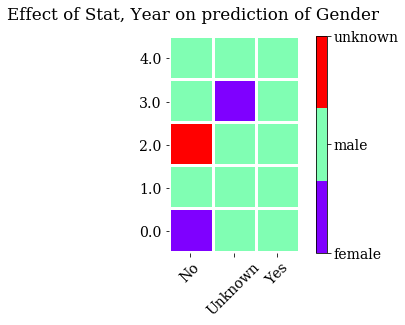

In [25]:
np.random.seed(42)
# clf = SVC(gamma='auto')
clf = DecisionTreeClassifier()
plot_classifier(data, ['Stat', 'Year bin'], 'Gender', clf)
plt.suptitle('Effect of Stat, Year on prediction of Gender')

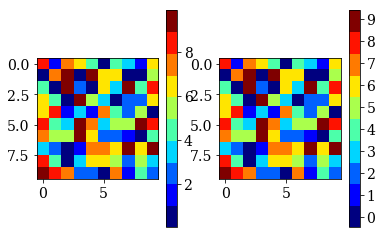

In [26]:
# The number of divisions of the cmap we have
k = 10

# Random test data
A = np.random.random((10,10))*k
c = cmap_discretize('jet', k)

# First show without
plt.subplot(121)
plt.imshow(A,interpolation='nearest',cmap=c)
plt.colorbar()

# Now label properly
plt.subplot(122)
plt.imshow(A,interpolation='nearest',cmap=c)

cb = plt.colorbar()
labels = np.arange(0,k,1)
loc    = labels + .5
cb.set_ticks(loc)
cb.set_ticklabels(labels)

In [27]:
X = np.ndindex(())

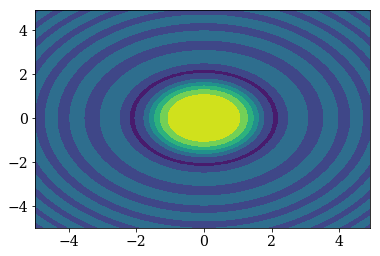

In [28]:
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)
xx, yy = np.meshgrid(x, y, sparse=True)
z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)
h = plt.contourf(x,y,z)

((100,), (100,), (100, 100))

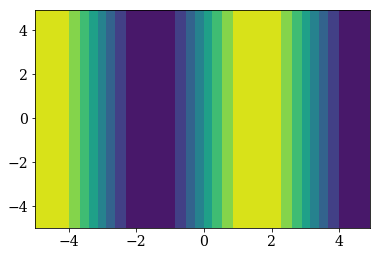

In [29]:
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)
xx, yy = np.meshgrid(x, y, sparse=True)
z = np.sin(xx + 0*yy)
h = plt.contourf(x,y,z)
x.shape, y.shape, z.shape

In [30]:
# xx

In [31]:
# from mlxtend.plotting import plot_decision_regions
# import matplotlib.pyplot as plt
# from sklearn import datasets
# from sklearn.svm import SVC

# # Loading some example data
# iris = datasets.load_iris()
# X = iris.data[:, [0, 2]]
# y = iris.target

# # Training a classifier
# svm = SVC(C=0.5, kernel='linear')
# svm.fit(x_train, y_train)


# # Plotting decision regions
# # plot_decision_regions(x_train.toarray(), y_train, clf=svm, legend=2)

# enc = E.encoders['x']
# enc.

# # Decision region for feature 3 = 1.5
# value = 0
# # Plot training sample with feature 3 = 1.5 +/- 0.75
# width = 0
# plot_decision_regions(X, y, clf=svm,
#                       filler_feature_values={2: value},
#                       filler_feature_ranges={2: width},
#                       legend=2, ax=ax)


# # Adding axes annotations
# plt.xlabel('sepal length [cm]')
# plt.ylabel('petal length [cm]')
# plt.title('SVM on Iris')
# plt.show()


In [32]:
# from mlxtend.plotting import plot_decision_regions

# n = 10
# plot_decision_regions(x_test[:n], y_test.astype(np.integer)[:n], 
#                       clf=clf, res=0.1);

In [33]:
# from sklearn.metrics import roc_curve, auc

# # The linear classifier doesn't produce class probabilities by default. We'll retrain it for probabilities.
# linear = SVC(kernel='linear', probability=True)
# linear.fit(x_train, y_train)

# # We'll need class probabilities from each of the classifiers
# y_linear = linear.predict_proba(x_test)
# y_tree  = tree.predict_proba(x_test)
# y_knn   = knn.predict_proba(x_test)

# # Compute the points on the curve
# # We pass the probability of the second class (KIA) as the y_score
# curve_linear = sklearn.metrics.roc_curve(y_test, y_linear[:, 1])
# curve_tree   = sklearn.metrics.roc_curve(y_test, y_tree[:, 1])
# curve_knn    = sklearn.metrics.roc_curve(y_test, y_knn[:, 1])

# # Compute Area Under the Curve
# auc_linear = auc(curve_linear[0], curve_linear[1])
# auc_tree   = auc(curve_tree[0], curve_tree[1])
# auc_knn    = auc(curve_knn[0], curve_knn[1])

# plt.plot(curve_linear[0], curve_linear[1], label='linear (area = %0.2f)' % auc_linear)
# plt.plot(curve_tree[0], curve_tree[1], label='tree (area = %0.2f)' % auc_tree)
# plt.plot(curve_knn[0], curve_knn[1], label='knn (area = %0.2f)'% auc_knn)

# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC curve');

# plt.legend();